In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
# Setup ------------------------------------------------------------------------

def simulate(move_from, move_to, motion_time, dt, noise = 0.025): 

  # Parameters ------------------------------------------------------------------------
  l1 = 0.3
  l2 = 0.33
  m1 = 14.4
  m2 = 10
  I1 = 0.025
  I2 = 0.045
  s1 = 0.11
  s2 = 0.16
  tau = 0.060 # Muscle activation time constant Source : (Li, 2007) -> voir énoncé
  # But the paper says 0.066 /!\
  
  x = np.concatenate((move_from, move_to)) #the state vector contains the state and the target


  a1 = I1 + I2 + m2*(l2**2)
  a2 = m2*l1*s2
  a3 = I2

  B_param = np.array([[0.5, 0.025], # Used to be 0.05, 0.025
                      [0.025, 0.5]])

  M = np.array([[a1, a3],
                [a3, a3]])
  M_inv = np.linalg.inv(M)
  P = np.dot(M_inv, B_param) #intermediate matrix used to simplify the notations

  #State system, Eq 6-7
  A_c = np.array([[0, 0, 1,       0,      0,              0],
                  [0, 0, 0,       1,      0,              0,],
                  [0, 0, -P[0,0], -P[0,1], M_inv[0,0], M_inv[0,1]],
                  [0, 0, -P[1,0], -P[1,1], M_inv[1,0], M_inv[1,1]],
                  [0, 0, 0,       0,      -1/tau,         -1/tau],
                  [0, 0, 0,       0,      -1/tau,         -1/tau]])

  B_c = np.array([[0, 0, 0, 0, 1/tau, 0],
                  [0, 0, 0, 0, 0, 1/tau]]).T # Transpose because B_c needs nxm

  u_dim = 2 #control input of shape (2,1)
  n_dim = A_c.shape[0] #dim of the state vector
  A = np.eye(n_dim) + dt*A_c
  B = dt*B_c

  # Augmentation of the system matrices to include the target
  n_dim_augment = 2*n_dim
  A_temp = A
  A = np.zeros(shape=(n_dim_augment,n_dim_augment))
  A[0:n_dim,0:n_dim] = A_temp
  A[n_dim:n_dim_augment,n_dim:n_dim_augment] = np.identity(n_dim)

  B_temp = B
  B = np.zeros(shape=(n_dim_augment, u_dim))
  B[0:n_dim] = B_temp


  # Definition of the cost-function and time -------------------------------------
  simulation_time = motion_time
  nStep = int(np.round(simulation_time/dt))
  N = nStep - 1
  Q = np.zeros(shape=(nStep, n_dim_augment, n_dim_augment))
  R = np.zeros(shape=(u_dim, u_dim))

                # W1      W2    W3
  w = np.array([1.5,1.5, 1.0,1.0, 0.1,0.1]) # weights assigned to each term of the cost function

  for i in range(n_dim):
    ei = 0*np.ndarray(shape=(2*n_dim))
    ei[i] = 1
    ei[i+n_dim] = -1
    Q[N,:,:] = Q[N,:,:] + w[i]*np.outer(ei,ei)


  # Perform backward recurrence --------------------------------------------------
  S_list = [None] * (N + 1) #
  L_list = [None] * (N + 1)

  S_list[N] = Q[N]

  for k in range(N - 1, -1, -1):
    Sk_plus_1 = S_list[k + 1]
    temp = np.linalg.inv(R + B.T @ Sk_plus_1 @ B + np.eye(u_dim) * 1e-10)  # Regularization
    Lk = temp @ B.T @ Sk_plus_1 @ A

    S_list[k] = Q[k] + A.T @ Sk_plus_1 @ (A - B @ Lk)
    L_list[k] = Lk

  # Perform forward simulation ---------------------------------------------------
  H = np.eye(n_dim_augment) # Observation matrix
  
  noise_std = noise
  process_std = noise

  Omega_omega = np.eye(n_dim_augment) * noise_std # Measurement noise covariance
  Omega_xi = np.eye(n_dim_augment) * process_std # Process noise covariance

  # Storage for results
  y_list = [None] * N
  Sigma_list = [None] * (N + 1) # state covariance
  x_hat_list = [None] * (N + 1) # state estimate
  K_list = [None] * N # kalman gains
  u_list = [None] * N # input list

  # Set initial conditions
  Sigma_list[0] = np.zeros((n_dim_augment, n_dim_augment))
  x_hat_list[0] = x

  # Kalman filter iterations
  for k in range(N):
      Sigma_k = Sigma_list[k]
      x_hat_k = x_hat_list[k]
      L_k = L_list[k]

      # Generate noisy measurement
      omega_k = np.random.multivariate_normal(mean=np.zeros(n_dim_augment), cov=Omega_omega).reshape(-1, 1)[:,0]
      y_k = H @ np.concat((x_hat_k[0:6], x[6:12])) + omega_k
      y_list[k] = y_k

      # Compute control input
      u_k = -L_k @ x_hat_k

      # Compute Kalman gain
      temp = np.linalg.inv(H @ Sigma_k @ H.T + Omega_omega)
      K_k = A @ Sigma_k @ H.T @ temp

      # Update covariance matrix
      Sigma_list[k + 1] = Omega_xi + (A - K_k @ H) @ Sigma_k @ A.T

      # Update state estimate
      x_hat_list[k + 1] = A @ x_hat_k + B @ u_k + K_k @ (y_k - H @ x_hat_k)

      # Store results
      K_list[k] = K_k
      u_list[k] = u_k
  
  return x_hat_list

## Question 1

In [3]:

#Initial State
x0 = np.array([0, 0, 0, 0, 0, 0])

#Target
motion_time = 1.2
timestep = 0.01
nStep = int(np.round(motion_time/timestep))

theta_1_target = math.pi/4
theta_2_target = math.pi/2
xt = np.array([theta_1_target, theta_2_target, theta_1_target/motion_time, theta_2_target/motion_time, 0, 0])



######## Question 1 ##########
basic_simulation = simulate(x0, xt, motion_time, timestep, noise=0.0025)

In [4]:
### Visualize arm from above, inspired by TP2
import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
my_layout = widgets.Layout()


@widgets.interact(
    timestamp=widgets.FloatSlider(0, min=0, max=len(basic_simulation)-1, step=1, layout=my_layout)

)

def visualize_arm(timestamp):
        
    l1 = 0.3
    l2 = 0.33

    # Extract the angles for the arm and the target
    theta_1, theta_2, _, _, _, _, theta_1_target, theta_2_target, _, _, _, _ = basic_simulation[int(timestamp)]

    # Function to compute the (x, y) coordinates of the joints and end effector
    def compute_positions(theta_1, theta_2, l1, l2):
        # Joint positions
        x1 = l1 * np.cos(theta_1)
        y1 = l1 * np.sin(theta_1)

        x2 = x1 + l2 * np.cos(theta_1 + theta_2)
        y2 = y1 + l2 * np.sin(theta_1 + theta_2)

        return (0, 0), (x1, y1), (x2, y2)

    # Compute positions for the current state
    base, joint, end_effector = compute_positions(theta_1, theta_2, l1, l2)

    # Compute positions for the target state
    _, target_joint, target_end_effector = compute_positions(theta_1_target, theta_2_target, l1, l2)

    # Visualization
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    ax.set_xlim(-0.8,0.8)
    ax.set_ylim(-0.6,0.8)

    # Plot the arm's current state
    ax.plot([base[0], joint[0], end_effector[0]], [base[1], joint[1], end_effector[1]], 
            marker='o', label='Current Arm State', color='blue')

    # Plot the target
    ax.scatter(target_end_effector[0], target_end_effector[1], 
            color='red', label='Target', s=100, zorder=5)

    # Add legend
    ax.legend()

    plt.show()


interactive(children=(FloatSlider(value=0.0, description='timestamp', max=119.0, step=1.0), Output()), _dom_cl…

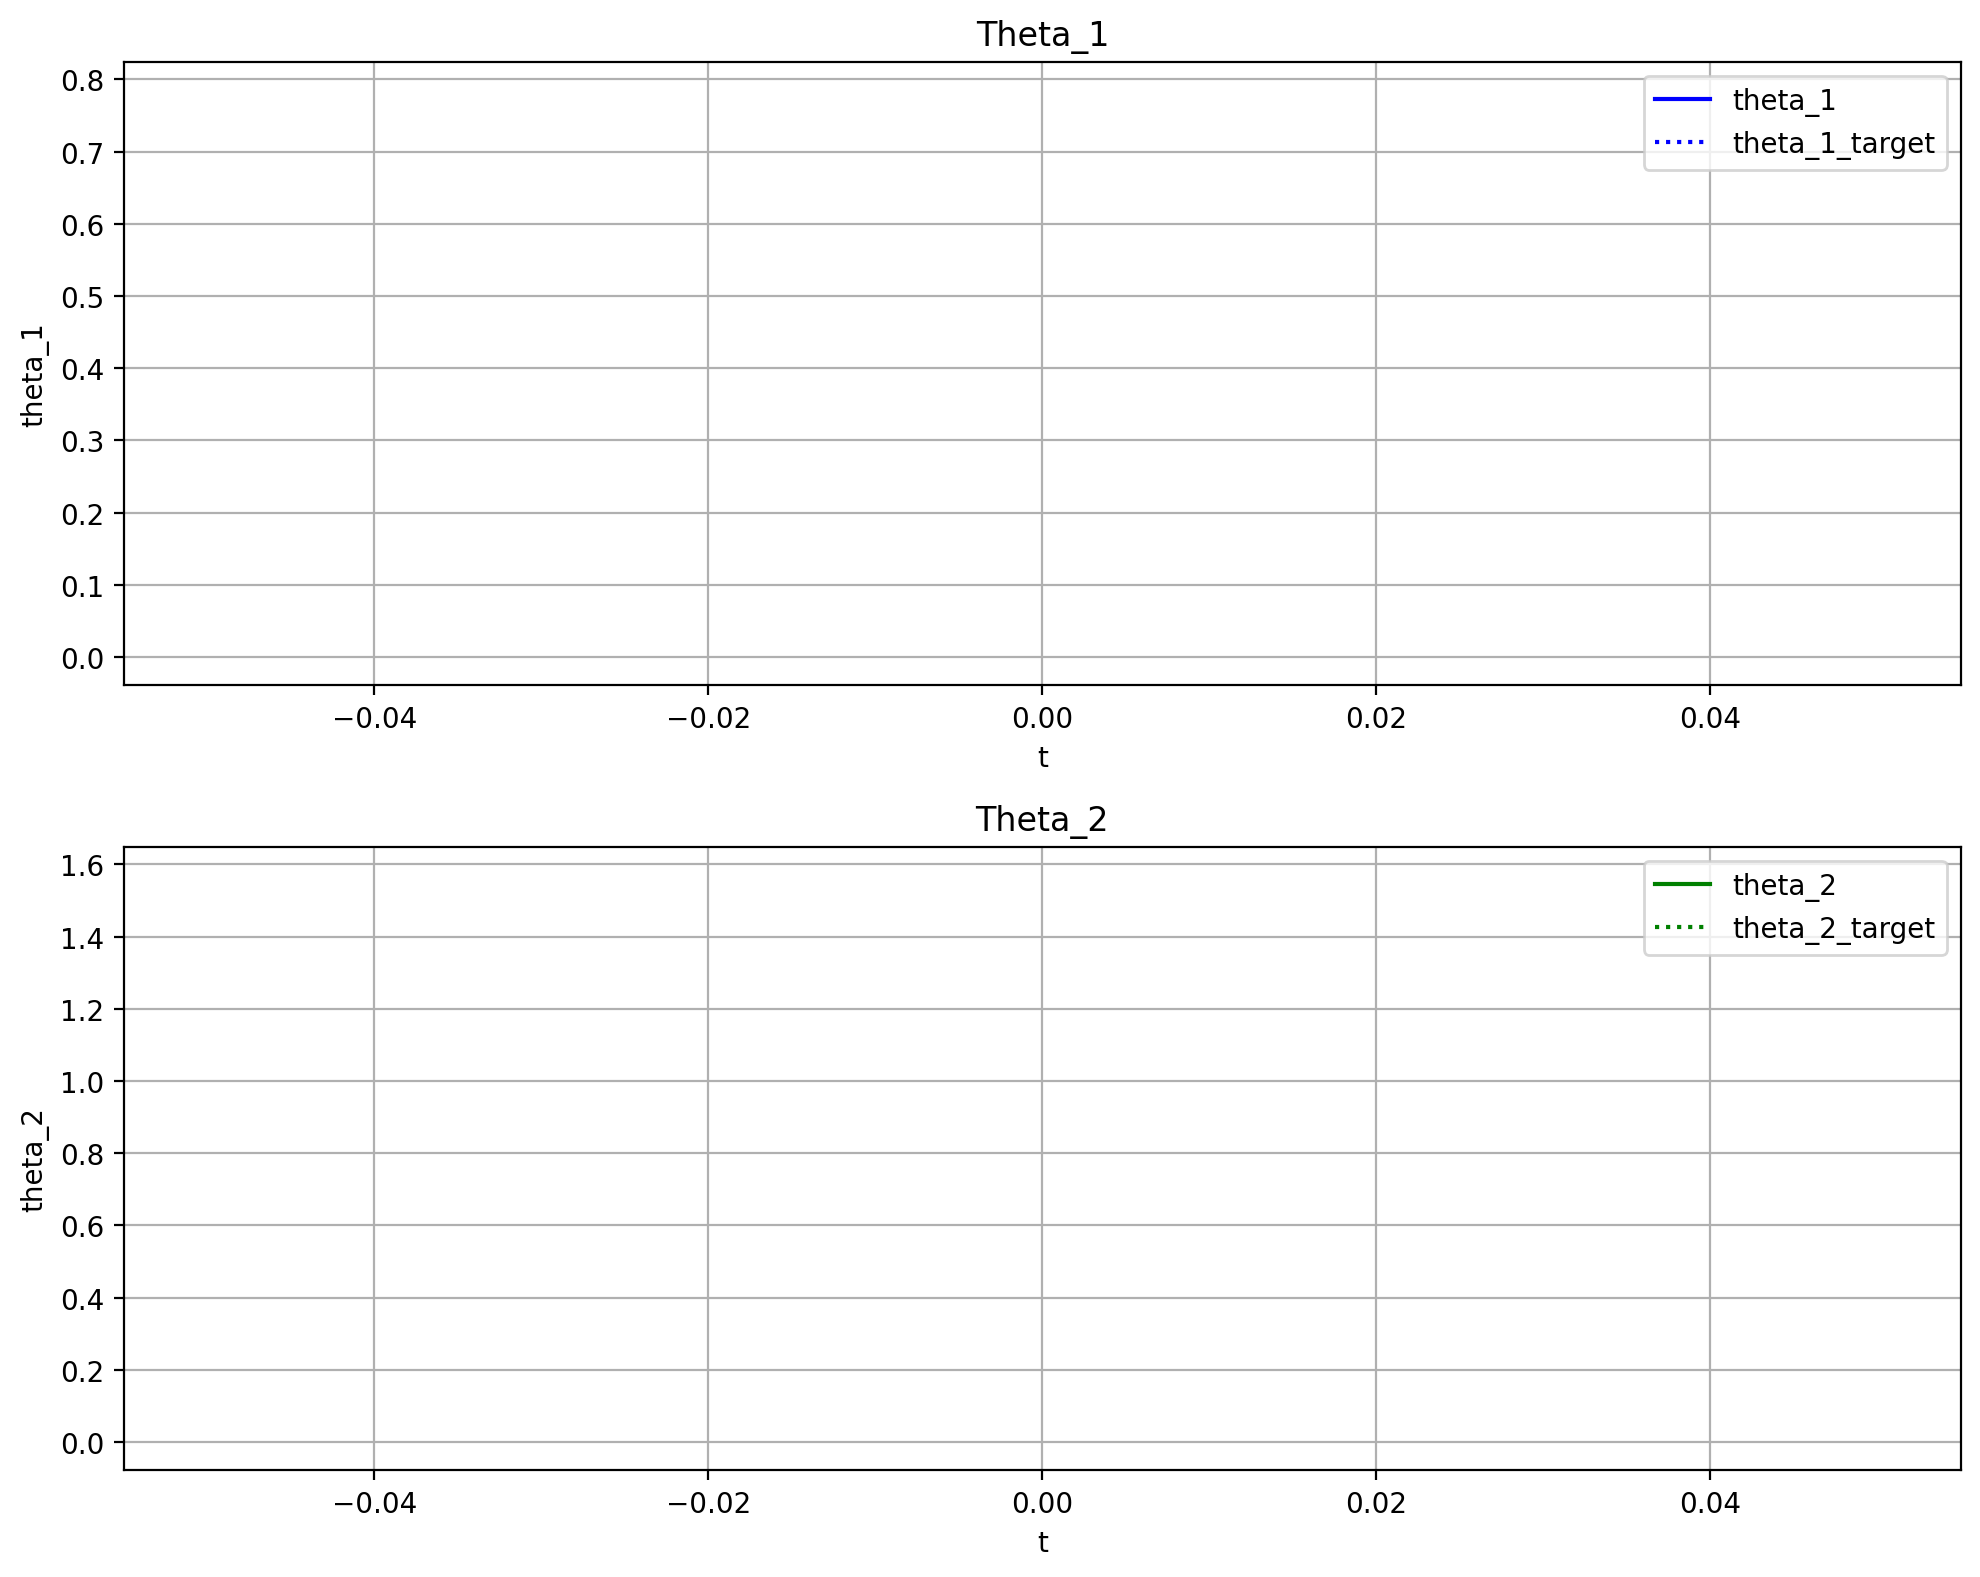

In [5]:
t = np.linspace(0, motion_time, nStep)
theta_1_traj = []
theta_2_traj = []

theta_1_targ = []
theta_2_targ = []

for x_ in basic_simulation:
  theta_1_traj.append(x_[0])
  theta_2_traj.append(x_[1])
  theta_1_targ.append(x_[6])
  theta_2_targ.append(x_[7])
  

fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # 2 rows, 1 column

axs[0].plot(t, theta_1_traj, label="theta_1", color="blue")
axs[0].plot(t, theta_1_targ, label="theta_1_target", color="blue", linestyle="dotted")
axs[0].set_title("Theta_1")
axs[0].set_xlabel("t")
axs[0].set_ylabel("theta_1")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(t, theta_2_traj, label="theta_2", color="green")
axs[1].plot(t, theta_2_targ, label="theta_2_target", color="green", linestyle="dotted")
axs[1].set_title("Theta_2")
axs[1].set_xlabel("t")
axs[1].set_ylabel("theta_2")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

## Question 2

Unclear if they want each target sequentially in the same motion time, or each target separately. Assume separate

In [6]:
######## Question 2 ##########
# Reaching movements towards different targets:
# Base target Cartesian position
l1 = 0.3
l2 = 0.33
x_central = l1 * np.cos(theta_1_target) + l2 * np.cos(theta_1_target + theta_2_target)
y_central = l1 * np.sin(theta_1_target) + l2 * np.sin(theta_1_target + theta_2_target)

########### Add all circular targets
radius = 0.18

# Get the 8 target xy
angles = np.linspace(0, 2 * np.pi, 8, endpoint=False)  # eight angles in radians
targets = [(x_central + radius * np.cos(angle), y_central + radius * np.sin(angle)) for angle in angles]

# Inverse kinematics to find  1 and theta 2 for each target
def inverse_kinematics(x, y, l1, l2):
    cos_theta_2 = (x**2 + y**2 - l1**2 - l2**2) / (2 * l1 * l2)

    theta_2 = np.arccos(np.clip(cos_theta_2, -1, 1))
    theta_1 = np.arctan2(y, x) - np.arctan2(l2 * np.sin(theta_2), l1 + l2 * np.cos(theta_2))

    return theta_1, theta_2

# Compute joint angles for each target
joint_angles = [inverse_kinematics(x, y, l1, l2) for x, y in targets]

### Simulate hitting each target ###
# Start with the one from Q1
test = simulate(x0, xt, motion_time, timestep)
list_of_reaching_movements = []

for angle_pair in joint_angles:
    this_target = [angle_pair[0], angle_pair[1], angle_pair[0]/motion_time, angle_pair[1]/motion_time, 0, 0]
    list_of_reaching_movements = list_of_reaching_movements + [simulate(x0, this_target, motion_time, timestep)]

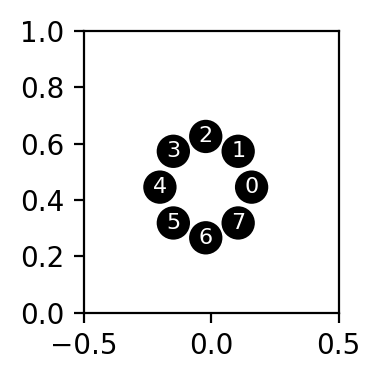

In [7]:
# Visualize targets
fig, axs = plt.subplots(1, 1, figsize=(2, 2))
axs.scatter([target[0] for target in targets], [target[1] for target in targets], label="Target pos")

# Add labels to each point
for i, target in enumerate(targets):
    axs.annotate(str(i), (target[0], target[1]), ha='center', va='center', fontsize=8, color='white',
                 bbox=dict(boxstyle='circle', facecolor='black', edgecolor='none'))
    
plt.xlim(-0.5, 0.5)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [8]:
### Visualize arm from above, inspired by TP2
import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
my_layout = widgets.Layout()

this_sim = list_of_reaching_movements[5]

@widgets.interact(
    timestamp=widgets.FloatSlider(0, min=0, max=len(this_sim)-1, step=1, layout=my_layout)

)

def visualize_arm(timestamp):
        
    l1 = 0.3
    l2 = 0.33

    # Extract the angles for the arm and the target
    theta_1, theta_2, _, _, _, _, theta_1_target, theta_2_target, _, _, _, _ = this_sim[int(timestamp)]

    # Function to compute the (x, y) coordinates of the joints and end effector
    def compute_positions(theta_1, theta_2, l1, l2):
        # Joint positions
        x1 = l1 * np.cos(theta_1)
        y1 = l1 * np.sin(theta_1)

        x2 = x1 + l2 * np.cos(theta_1 + theta_2)
        y2 = y1 + l2 * np.sin(theta_1 + theta_2)

        return (0, 0), (x1, y1), (x2, y2)

    # Compute positions for the current state
    base, joint, end_effector = compute_positions(theta_1, theta_2, l1, l2)

    # Compute positions for the target state
    _, target_joint, target_end_effector = compute_positions(theta_1_target, theta_2_target, l1, l2)

    # Visualization
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    ax.set_xlim(-0.8,0.8)
    ax.set_ylim(-0.6,0.8)

    # Plot the arm's current state
    ax.plot([base[0], joint[0], end_effector[0]], [base[1], joint[1], end_effector[1]], 
            marker='o', label='Current Arm State', color='blue')

    # Plot the target
    ax.scatter(target_end_effector[0], target_end_effector[1], 
            color='red', label='Target', s=100, zorder=5)

    # Add legend
    ax.legend()

    plt.show()

interactive(children=(FloatSlider(value=0.0, description='timestamp', max=119.0, step=1.0), Output()), _dom_cl…

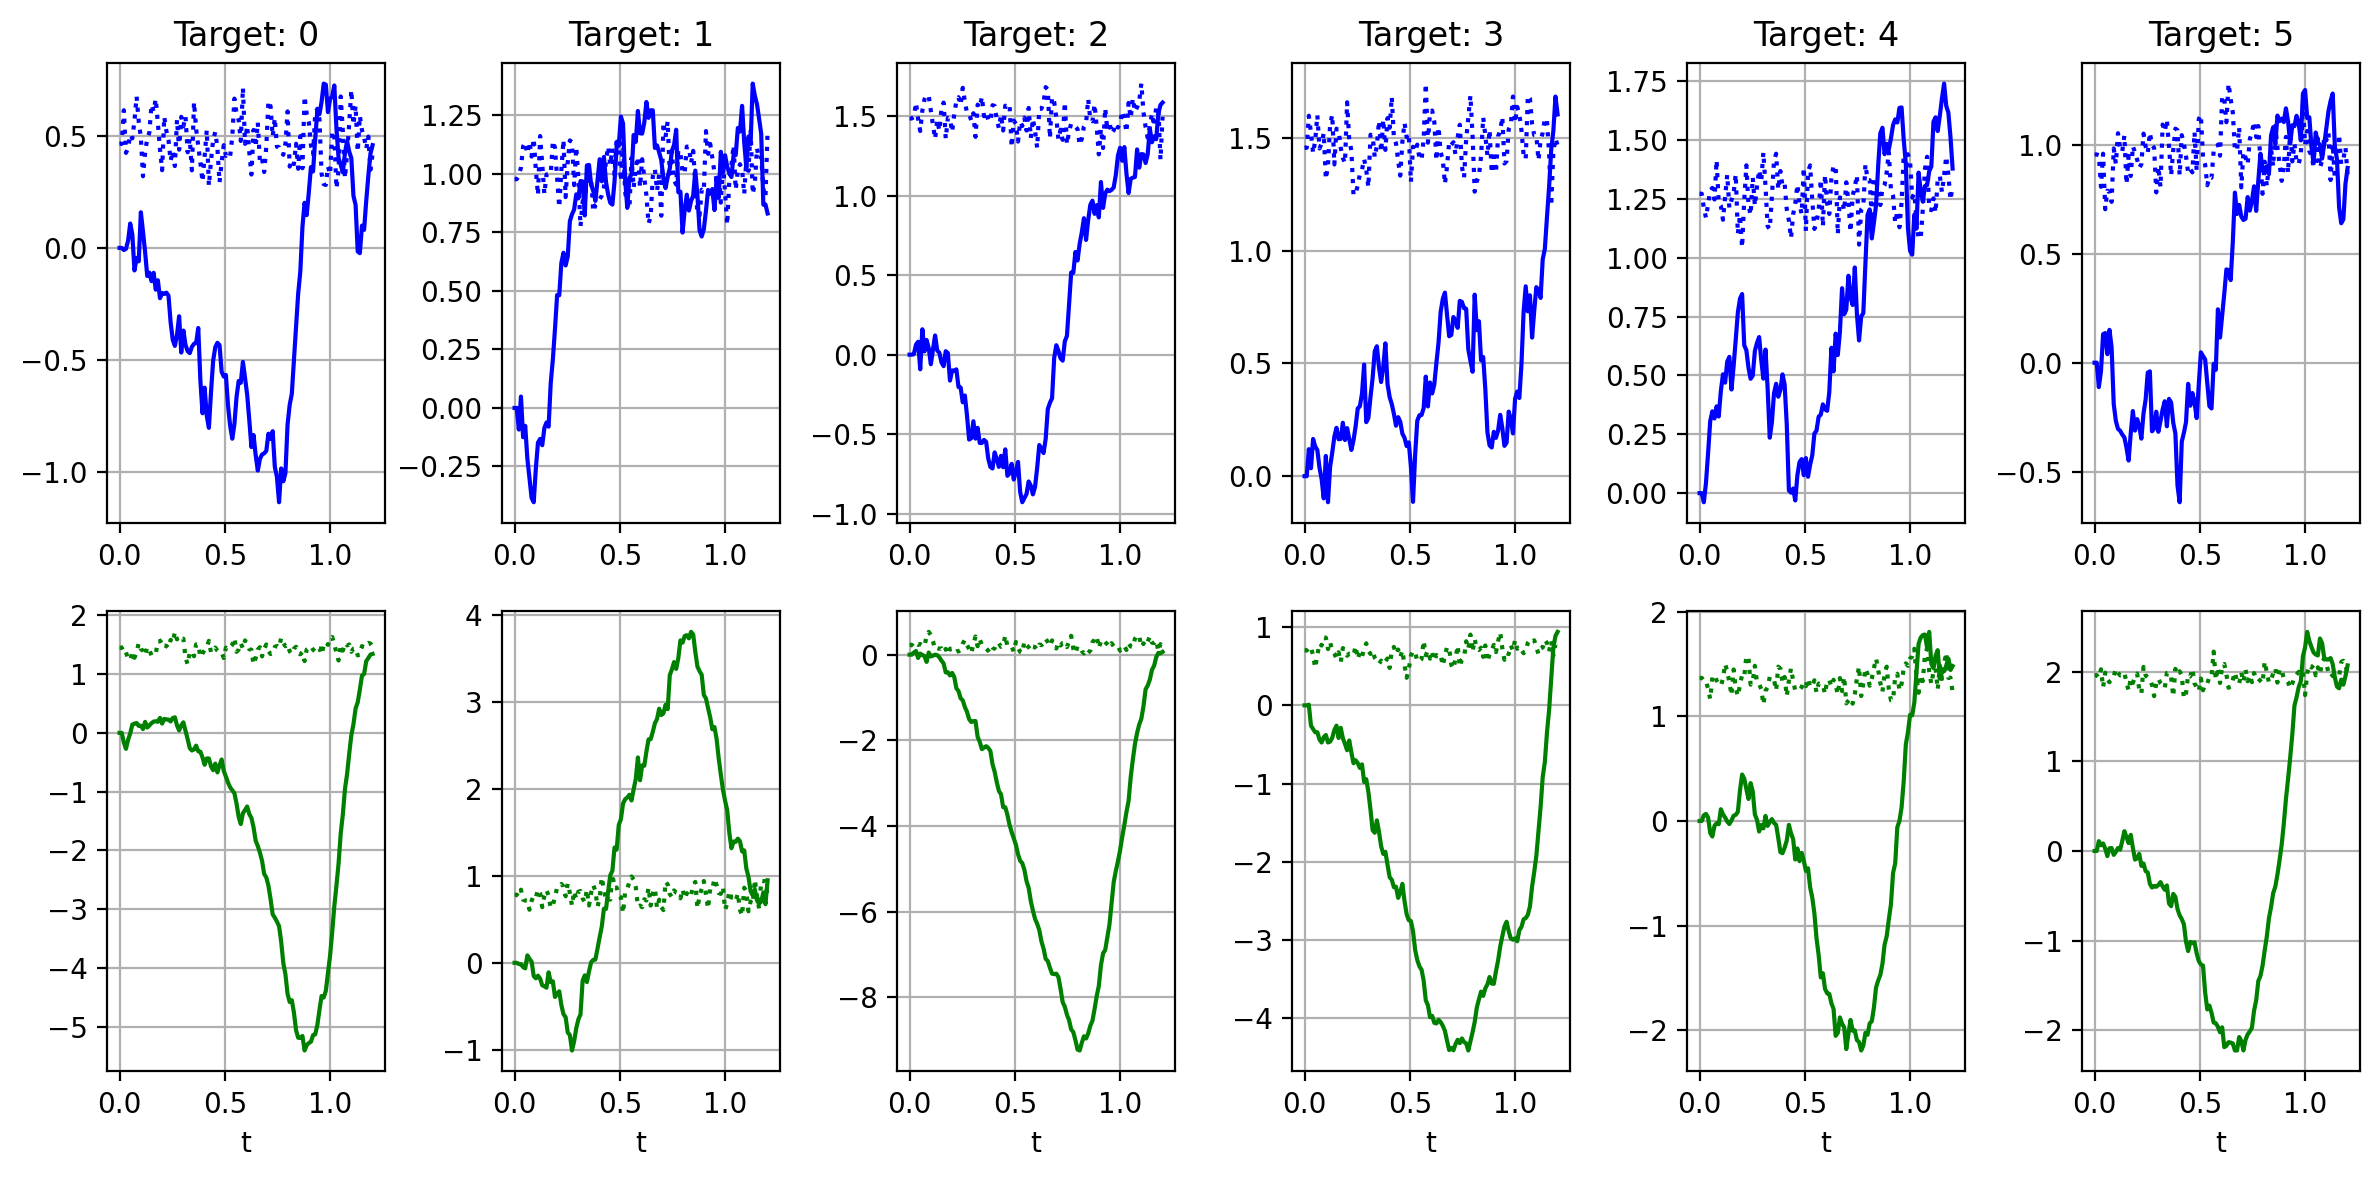

In [9]:
target_angles = joint_angles[0:6]
graphs_to_gen = len(list_of_reaching_movements[0:6])

fig, axs = plt.subplots(2, graphs_to_gen, figsize=(12, 6))

for i in range(0, graphs_to_gen):

  t = np.linspace(0, motion_time, nStep)
  theta_1_traj = []
  theta_2_traj = []
  theta_1_targ = []
  theta_2_targ = []
  for x_ in list_of_reaching_movements[i] :
    theta_1_traj.append(x_[0])
    theta_2_traj.append(x_[1])
    theta_1_targ.append(x_[6])
    theta_2_targ.append(x_[7])

  axs[0][i].plot(t, theta_1_traj, color="blue", label="theta_1")
  axs[0][i].plot(t, theta_1_targ, label="theta_1_target", color="blue", linestyle="dotted")
  axs[0][i].set_title("Target: " + str(i))
  axs[0][i].grid(True)

  axs[1][i].plot(t, theta_2_traj, color="green", label="theta_2")
  axs[1][i].plot(t, theta_2_targ, label="theta_2_target", color="green", linestyle="dotted")
  axs[1][i].set_xlabel("t")
  axs[1][i].grid(True)

plt.tight_layout()
plt.show()

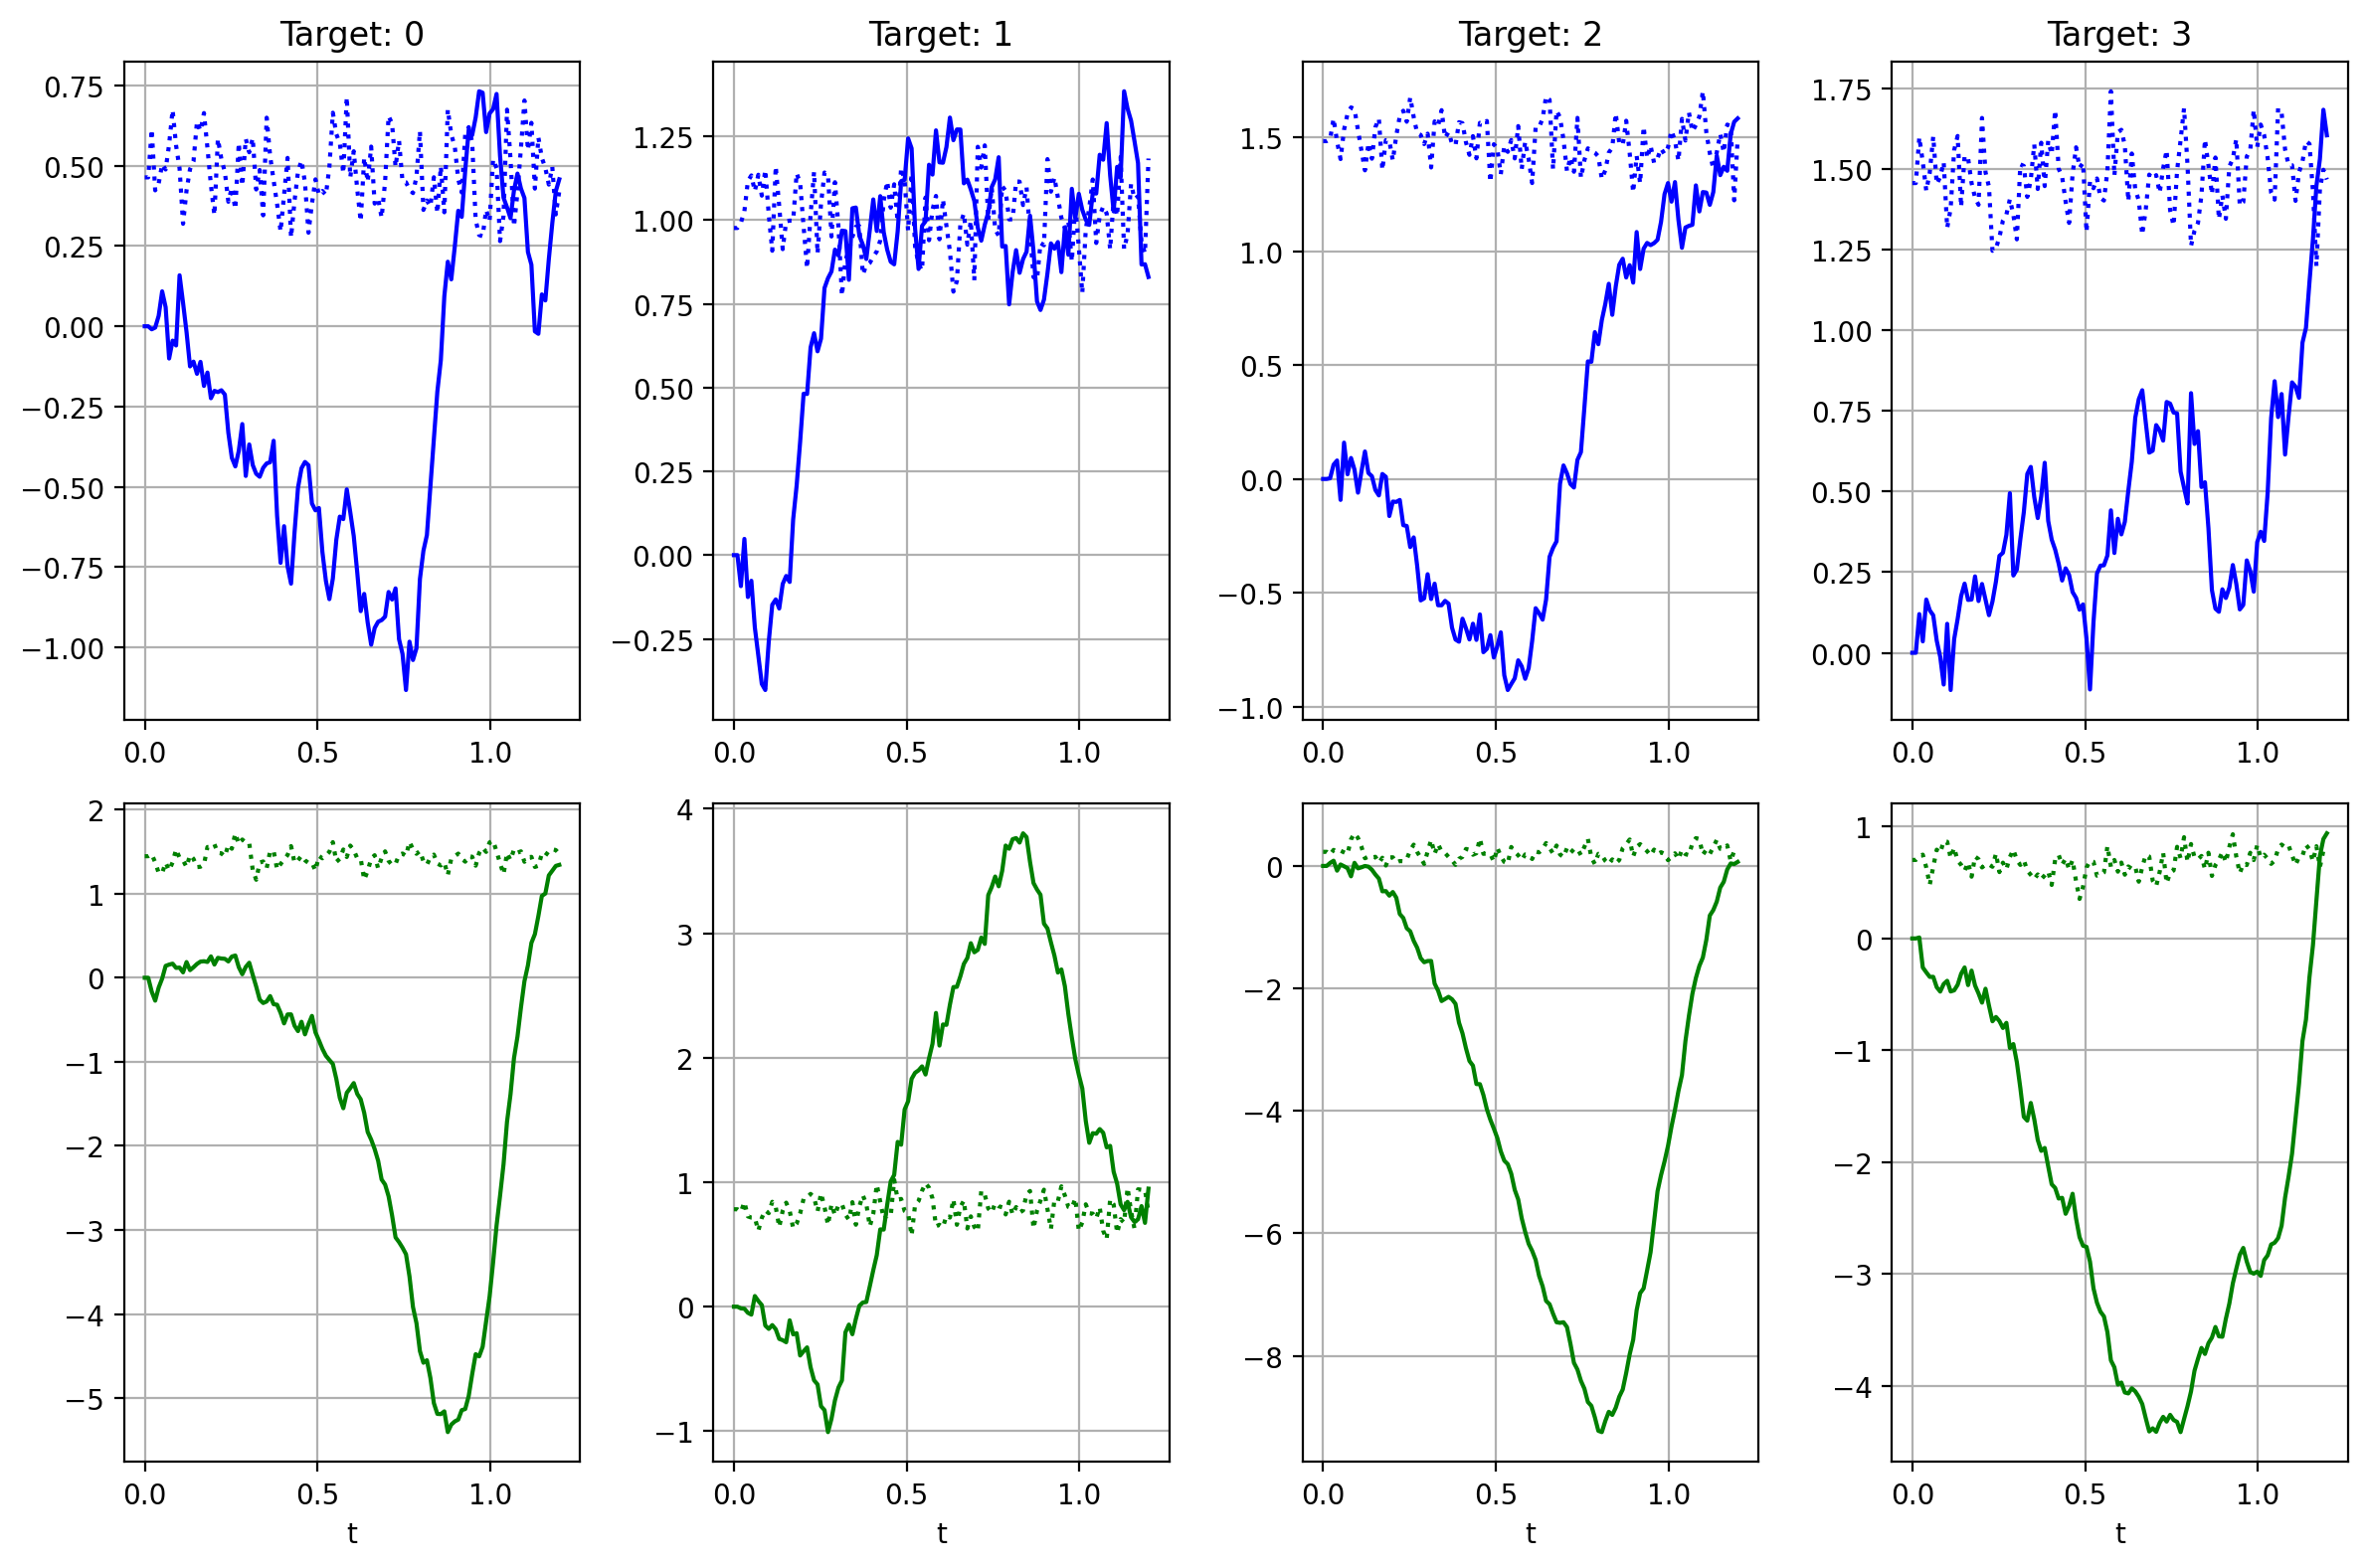

In [10]:
target_angles = joint_angles[4:8]

graphs_to_gen = len(this_sim[4:8])

fig, axs = plt.subplots(2, graphs_to_gen, figsize=(12, 8))  # 2 rows, 1 column

for i in range(0, graphs_to_gen):

  t = np.linspace(0, motion_time, nStep)
  theta_1_traj = []
  theta_2_traj = []
  theta_1_targ = []
  theta_2_targ = []
  for x_ in list_of_reaching_movements[i] :
    theta_1_traj.append(x_[0])
    theta_2_traj.append(x_[1])
    theta_1_targ.append(x_[6])
    theta_2_targ.append(x_[7])

  axs[0][i].plot(t, theta_1_traj, color="blue", label="theta_1")
  axs[0][i].plot(t, theta_1_targ, label="theta_1_target", color="blue", linestyle="dotted")
  axs[0][i].set_title("Target: " + str(i))
  axs[0][i].grid(True)

  axs[1][i].plot(t, theta_2_traj, color="green", label="theta_2")
  axs[1][i].plot(t, theta_2_targ, label="theta_2_target", color="green", linestyle="dotted")
  axs[1][i].set_xlabel("t")
  axs[1][i].grid(True)

plt.tight_layout()
plt.show()

## Question 3
Visual perturbation simulation with jumping targets

In [11]:
def simulate_with_jump_torque(move_from, move_to_initial, move_to_final, target_disturbance_time, 
                              motion_time, dt, external_torque = [0,0,0,0,0,0,0,0,0,0,0,0], time_delay = 0, noise = 0.025): 

    # Parameters ------------------------------------------------------------------------
    l1 = 0.3
    l2 = 0.33
    m1 = 1.4
    m2 = 1
    I1 = 0.025
    I2 = 0.045
    s1 = 0.11
    s2 = 0.16
    tau = 0.060 # Muscle activation time constant Source : (Li, 2007) -> voir énoncé
    # But the paper says 0.066 /!\

    x = np.concatenate((move_from, move_to_initial)) #the state vector contains the state and the target


    a1 = I1 + I2 + m2*(l2**2)
    a2 = m2*l1*s2
    a3 = I2

    B_param = np.array([[0.5, 0.025], # Used to be 0.05, 0.025
                        [0.025, 0.5]])
    M = np.array([[a1, a3],
                [a3, a3]])
    M_inv = np.linalg.inv(M)
    P = np.dot(M_inv, B_param) #intermediate matrix used to simplify the notations

    #State system, Eq 6-7
    A_c = np.array([[0, 0, 1,       0,      0,              0],
                    [0, 0, 0,       1,      0,              0,],
                    [0, 0, -P[0,0], -P[0,1], M_inv[0,0], M_inv[0,1]],
                    [0, 0, -P[1,0], -P[1,1], M_inv[1,0], M_inv[1,1]],
                    [0, 0, 0,       0,      -1/tau,         -1/tau],
                    [0, 0, 0,       0,      -1/tau,         -1/tau]])

    B_c = np.array([[0, 0, 0, 0, 1/tau, 0],
                    [0, 0, 0, 0, 0, 1/tau]]).T # Transpose because B_c needs nxm

    u_dim = 2 #control input of shape (2,1)
    n_dim = A_c.shape[0] #dim of the state vector
    A = np.eye(n_dim) + dt*A_c
    B = dt*B_c

    # Augmentation of the system matrices to include the target
    n_dim_augment = 2*n_dim
    A_temp = A
    A = np.zeros(shape=(n_dim_augment,n_dim_augment))
    A[0:n_dim,0:n_dim] = A_temp
    A[n_dim:n_dim_augment,n_dim:n_dim_augment] = np.identity(n_dim)

    B_temp = B
    B = np.zeros(shape=(n_dim_augment, u_dim))
    B[0:n_dim] = B_temp


    # Definition of the cost-function and time -------------------------------------
    simulation_time = motion_time
    nStep = int(np.round(simulation_time/dt))
    N = nStep - 1
    Q = np.zeros(shape=(nStep, n_dim_augment, n_dim_augment))
    R = np.zeros(shape=(u_dim, u_dim))

                # W1      W2    W3
    w = np.array([1.5,1.5, 1,1, 0.1,0.1]) # weights assigned to each term of the cost function

    for i in range(n_dim):
        ei = 0*np.ndarray(shape=(2*n_dim))
        ei[i] = 1
        ei[i+n_dim] = -1
        Q[N,:,:] = Q[N,:,:] + w[i]*np.outer(ei,ei)
    

    # Perform backward recurrence --------------------------------------------------
    S_list = [None] * (N + 1) #
    L_list = [None] * (N + 1)

    S_list[N] = Q[N]

    for k in range(N - 1, -1, -1):
        Sk_plus_1 = S_list[k + 1]
        temp = np.linalg.inv(R + B.T @ Sk_plus_1 @ B)
        temp = np.linalg.inv(R + B.T @ Sk_plus_1 @ B + np.eye(u_dim) * 1e-10)  # Regularization

        Lk = temp @ B.T @ Sk_plus_1 @ A

        S_list[k] = Q[k] + A.T @ Sk_plus_1 @ (A - B @ Lk)
        L_list[k] = Lk

    # Perform forward simulation ---------------------------------------------------
    H = np.eye(n_dim_augment) # Observation matrix

    noise_std = noise
    process_std = noise

    Omega_omega = np.eye(n_dim_augment)*noise_std # Measurement noise covariance
    Omega_xi = np.eye(n_dim_augment)*process_std # Process noise covariance

    # Storage for results
    y_list = [None] * N
    Sigma_list = [None] * (N + 1) # state covariance
    x_hat_list = [None] * (N + 1) # state estimate
    K_list = [None] * N # kalman gains
    u_list = [None] * N # input list

    # Set initial conditions
    Sigma_list[0] = np.zeros((n_dim_augment, n_dim_augment))
    x_hat_list[0] = x
    current_target = move_to_initial

    # Kalman filter iterations
    #### For initial target
    for k in range(N):
        Sigma_k = Sigma_list[k]
        x_hat_k = x_hat_list[k]

        if (k == int(np.floor(N * target_disturbance_time))):
            current_target = move_to_final

        L_k = L_list[k]

        # Generate noisy measurement
        omega_k = np.random.multivariate_normal(mean=np.zeros(n_dim_augment), cov=Omega_omega).reshape(-1, 1)[:,0]
        y_k = H @ np.concat((x_hat_k[0:6], current_target)) + omega_k
        y_list[k] = y_k

        # Compute control input
        u_k = -L_k @ x_hat_k

        # Compute Kalman gain
        temp = np.linalg.inv(H @ Sigma_k @ H.T + Omega_omega)
        K_k = A @ Sigma_k @ H.T @ temp

        # Update covariance matrix
        Sigma_list[k + 1] = Omega_xi + (A - K_k @ H) @ Sigma_k @ A.T

        # Update state estimate
        x_hat_list[k + 1] = A @ x_hat_k + B @ u_k + K_k @ (y_k - H @ x_hat_k) + external_torque

        # Store results
        K_list[k] = K_k
        u_list[k] = u_k
    

    return x_hat_list

In [12]:
timestep = 0.01
motion_time = 0.6

# indicates where in the simulation the target should be disturbed
target_disturbance_time = 0.5 ## This is a ratio between 0.0 and 1.0 of the above motion time

xt_initial = np.array([theta_1_target, theta_2_target, theta_1_target/motion_time, theta_2_target/motion_time, 0, 0])

## For the final target, we choose one of the previously defined targets in the circle
target = joint_angles[6]
xt_final = np.array([-target[0], -target[1], -target[0]/motion_time, -target[1]/motion_time, 0, 0]) 

simulated_with_jump = simulate_with_jump_torque(x0, xt_initial, xt_final, target_disturbance_time, motion_time, timestep)

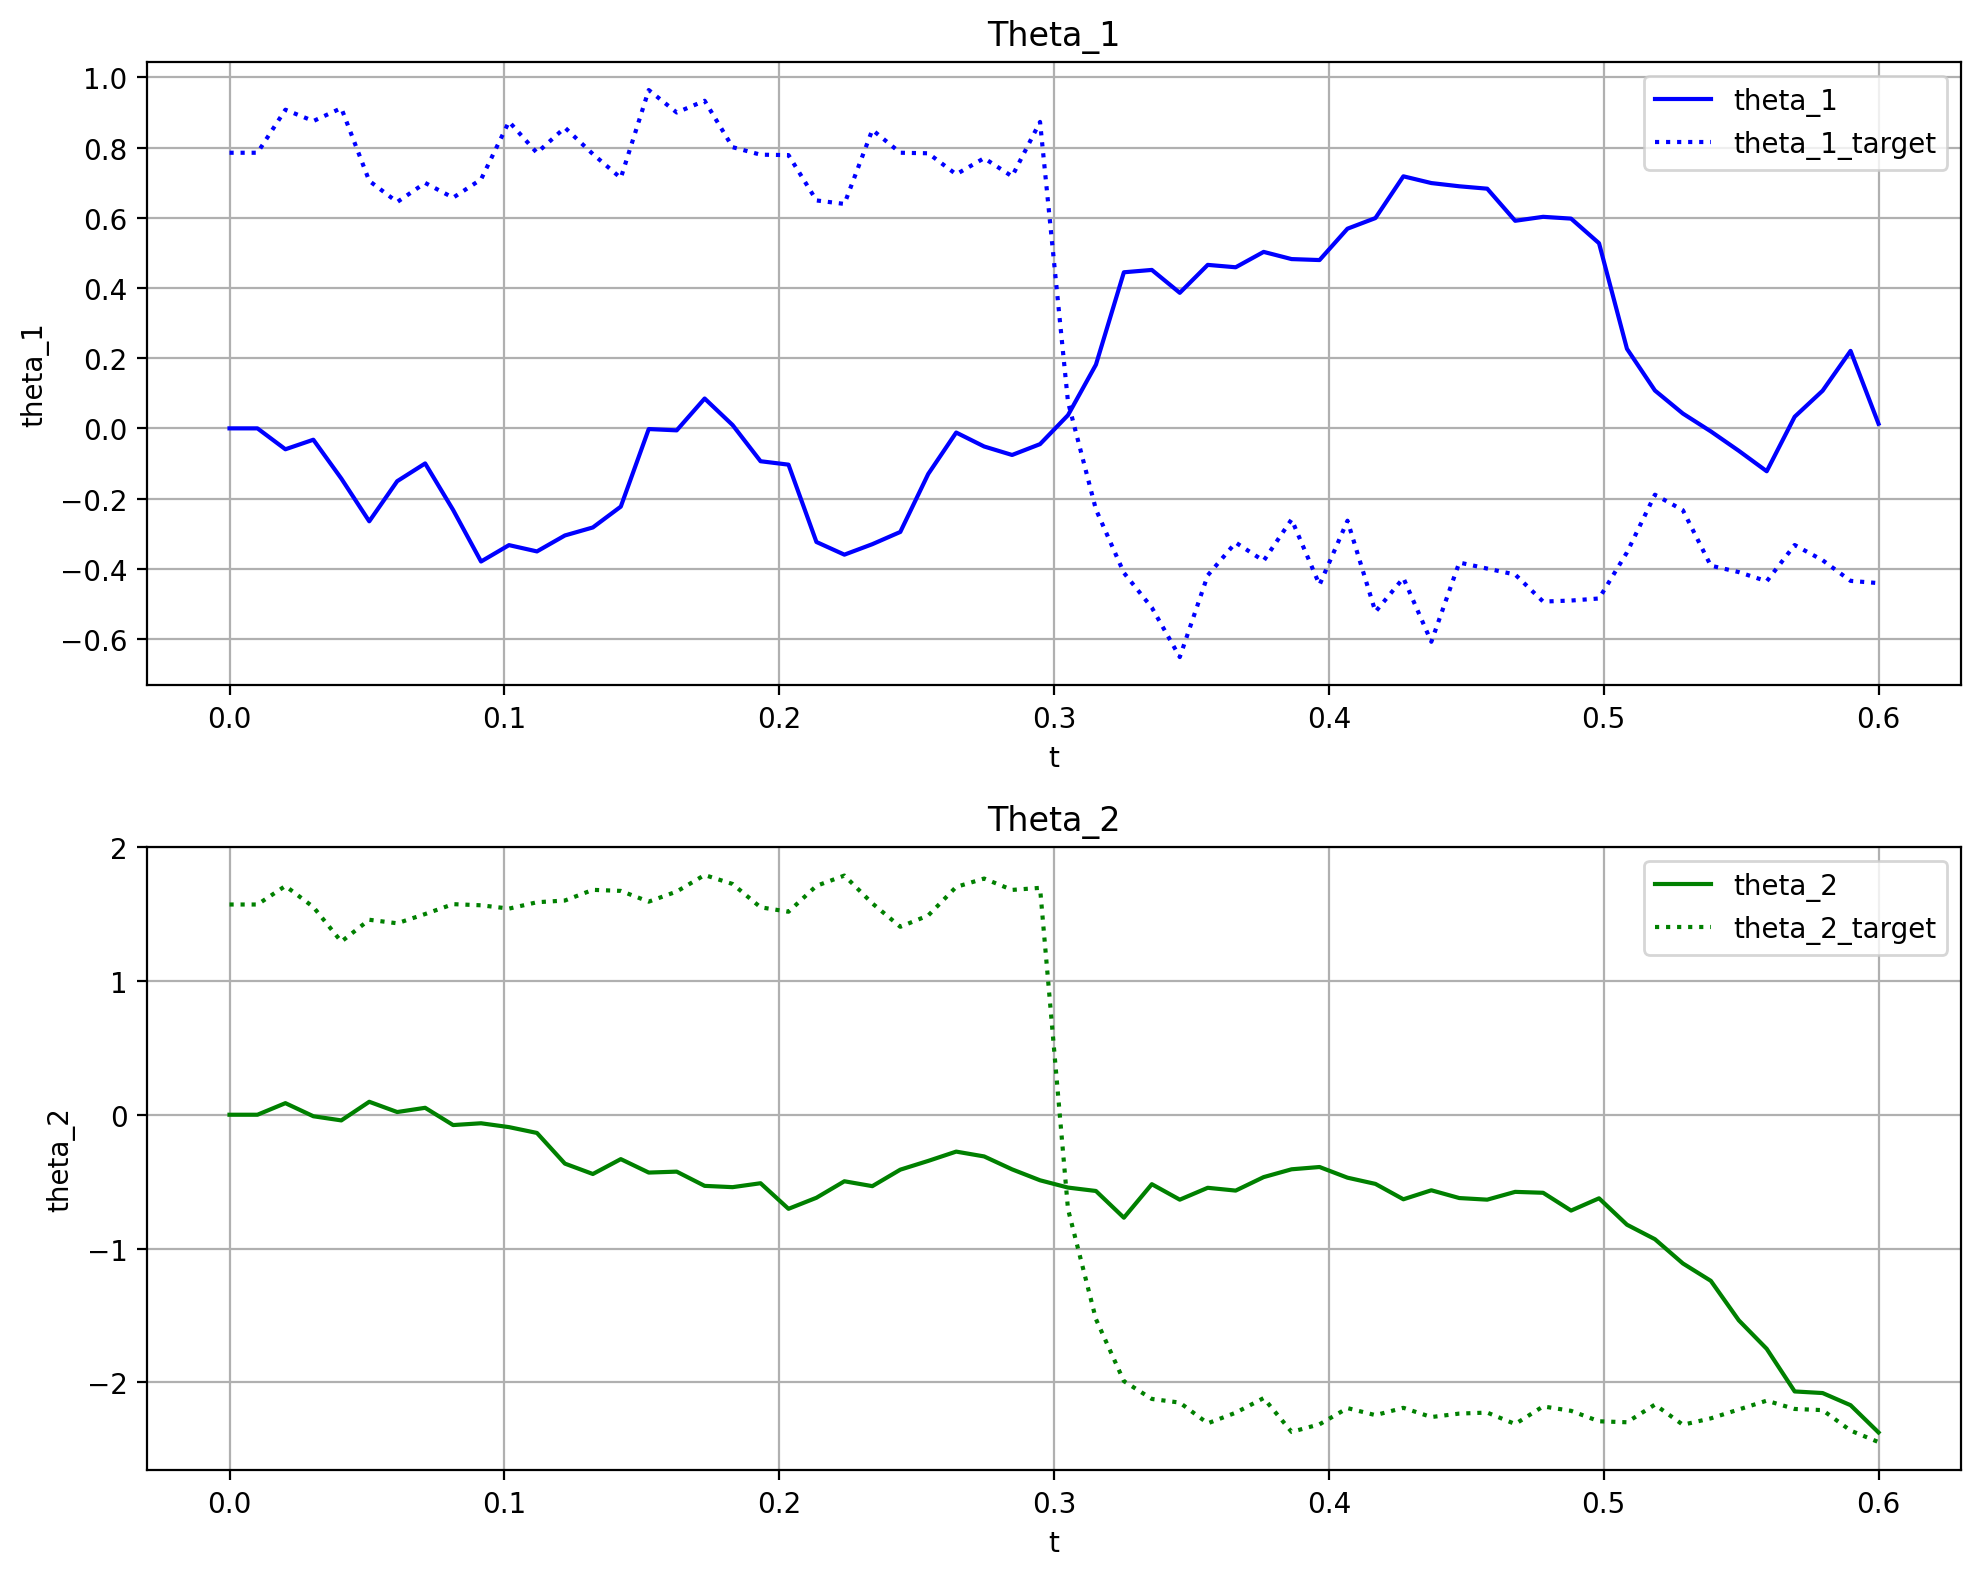

In [13]:
## Visualize target change simulation
nStep = int(np.round(motion_time/timestep))
t = np.linspace(0, motion_time, nStep)
theta_1_traj = []
theta_2_traj = []

theta_1_targ = []
theta_2_targ = []

for x_ in simulated_with_jump:
  theta_1_traj.append(x_[0])
  theta_2_traj.append(x_[1])
  theta_1_targ.append(x_[6])
  theta_2_targ.append(x_[7])
  

fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # 2 rows, 1 column

axs[0].plot(t, theta_1_traj, label="theta_1", color="blue")
axs[0].plot(t, theta_1_targ, label="theta_1_target", color="blue", linestyle="dotted")
axs[0].set_title("Theta_1")
axs[0].set_xlabel("t")
axs[0].set_ylabel("theta_1")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(t, theta_2_traj, label="theta_2", color="green")
axs[1].plot(t, theta_2_targ, label="theta_2_target", color="green", linestyle="dotted")
axs[1].set_title("Theta_2")
axs[1].set_xlabel("t")
axs[1].set_ylabel("theta_2")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [14]:
### Visualize arm from above, inspired by TP2
import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
my_layout = widgets.Layout()

@widgets.interact(
    timestamp=widgets.FloatSlider(0, min=0, max=len(simulated_with_jump)-1, step=1, layout=my_layout)

)

def visualize_arm(timestamp):
        
    l1 = 0.3
    l2 = 0.33

    # Extract the angles for the arm and the target
    theta_1, theta_2, _, _, _, _, theta_1_target, theta_2_target, _, _, _, _ = simulated_with_jump[int(timestamp)]

    # Function to compute the (x, y) coordinates of the joints and end effector
    def compute_positions(theta_1, theta_2, l1, l2):
        # Joint positions
        x1 = l1 * np.cos(theta_1)
        y1 = l1 * np.sin(theta_1)

        x2 = x1 + l2 * np.cos(theta_1 + theta_2)
        y2 = y1 + l2 * np.sin(theta_1 + theta_2)

        return (0, 0), (x1, y1), (x2, y2)

    # Compute positions for the current state
    base, joint, end_effector = compute_positions(theta_1, theta_2, l1, l2)

    # Compute positions for the target state
    _, target_joint, target_end_effector = compute_positions(theta_1_target, theta_2_target, l1, l2)

    # Visualization
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    ax.set_xlim(-0.8,0.8)
    ax.set_ylim(-0.6,0.8)

    # Plot the arm's current state
    ax.plot([base[0], joint[0], end_effector[0]], [base[1], joint[1], end_effector[1]], 
            marker='o', label='Current Arm State', color='blue')

    # Plot the target
    ax.scatter(target_end_effector[0], target_end_effector[1], 
            color='red', label='Target', s=100, zorder=5)

    # Add legend
    ax.legend()

    plt.show()


interactive(children=(FloatSlider(value=0.0, description='timestamp', max=59.0, step=1.0), Output()), _dom_cla…

## Question 4
Mechanical perturbation simulation with external torque applied

ASSUMED that the torque is **continuously** applied

In [15]:
timestep = 0.01
motion_time = 0.9
external_torque_shoulder = 1.0  # Shoulder torque
external_torque_elbow = .5    # elbow torque

### Remember: first 6 are the starting/ongoing, last 6 are the target
torque_disturbance = np.array([0, 0, external_torque_shoulder, external_torque_elbow, 0, 0, 0, 0, 0, 0, 0, 0])

simulated_with_torque = simulate_with_jump_torque(x0, xt_initial, xt_final, target_disturbance_time, motion_time, timestep, torque_disturbance)

xt_initial = np.array([theta_1_target, theta_2_target, 0, 0, 0, 0])
xt_final = np.array([-target[0], -target[1], 0, 0, 0, 0]) 

simulated_with_torque = simulate_with_jump_torque(x0, xt_initial, xt_final, target_disturbance_time, motion_time, timestep, torque_disturbance)

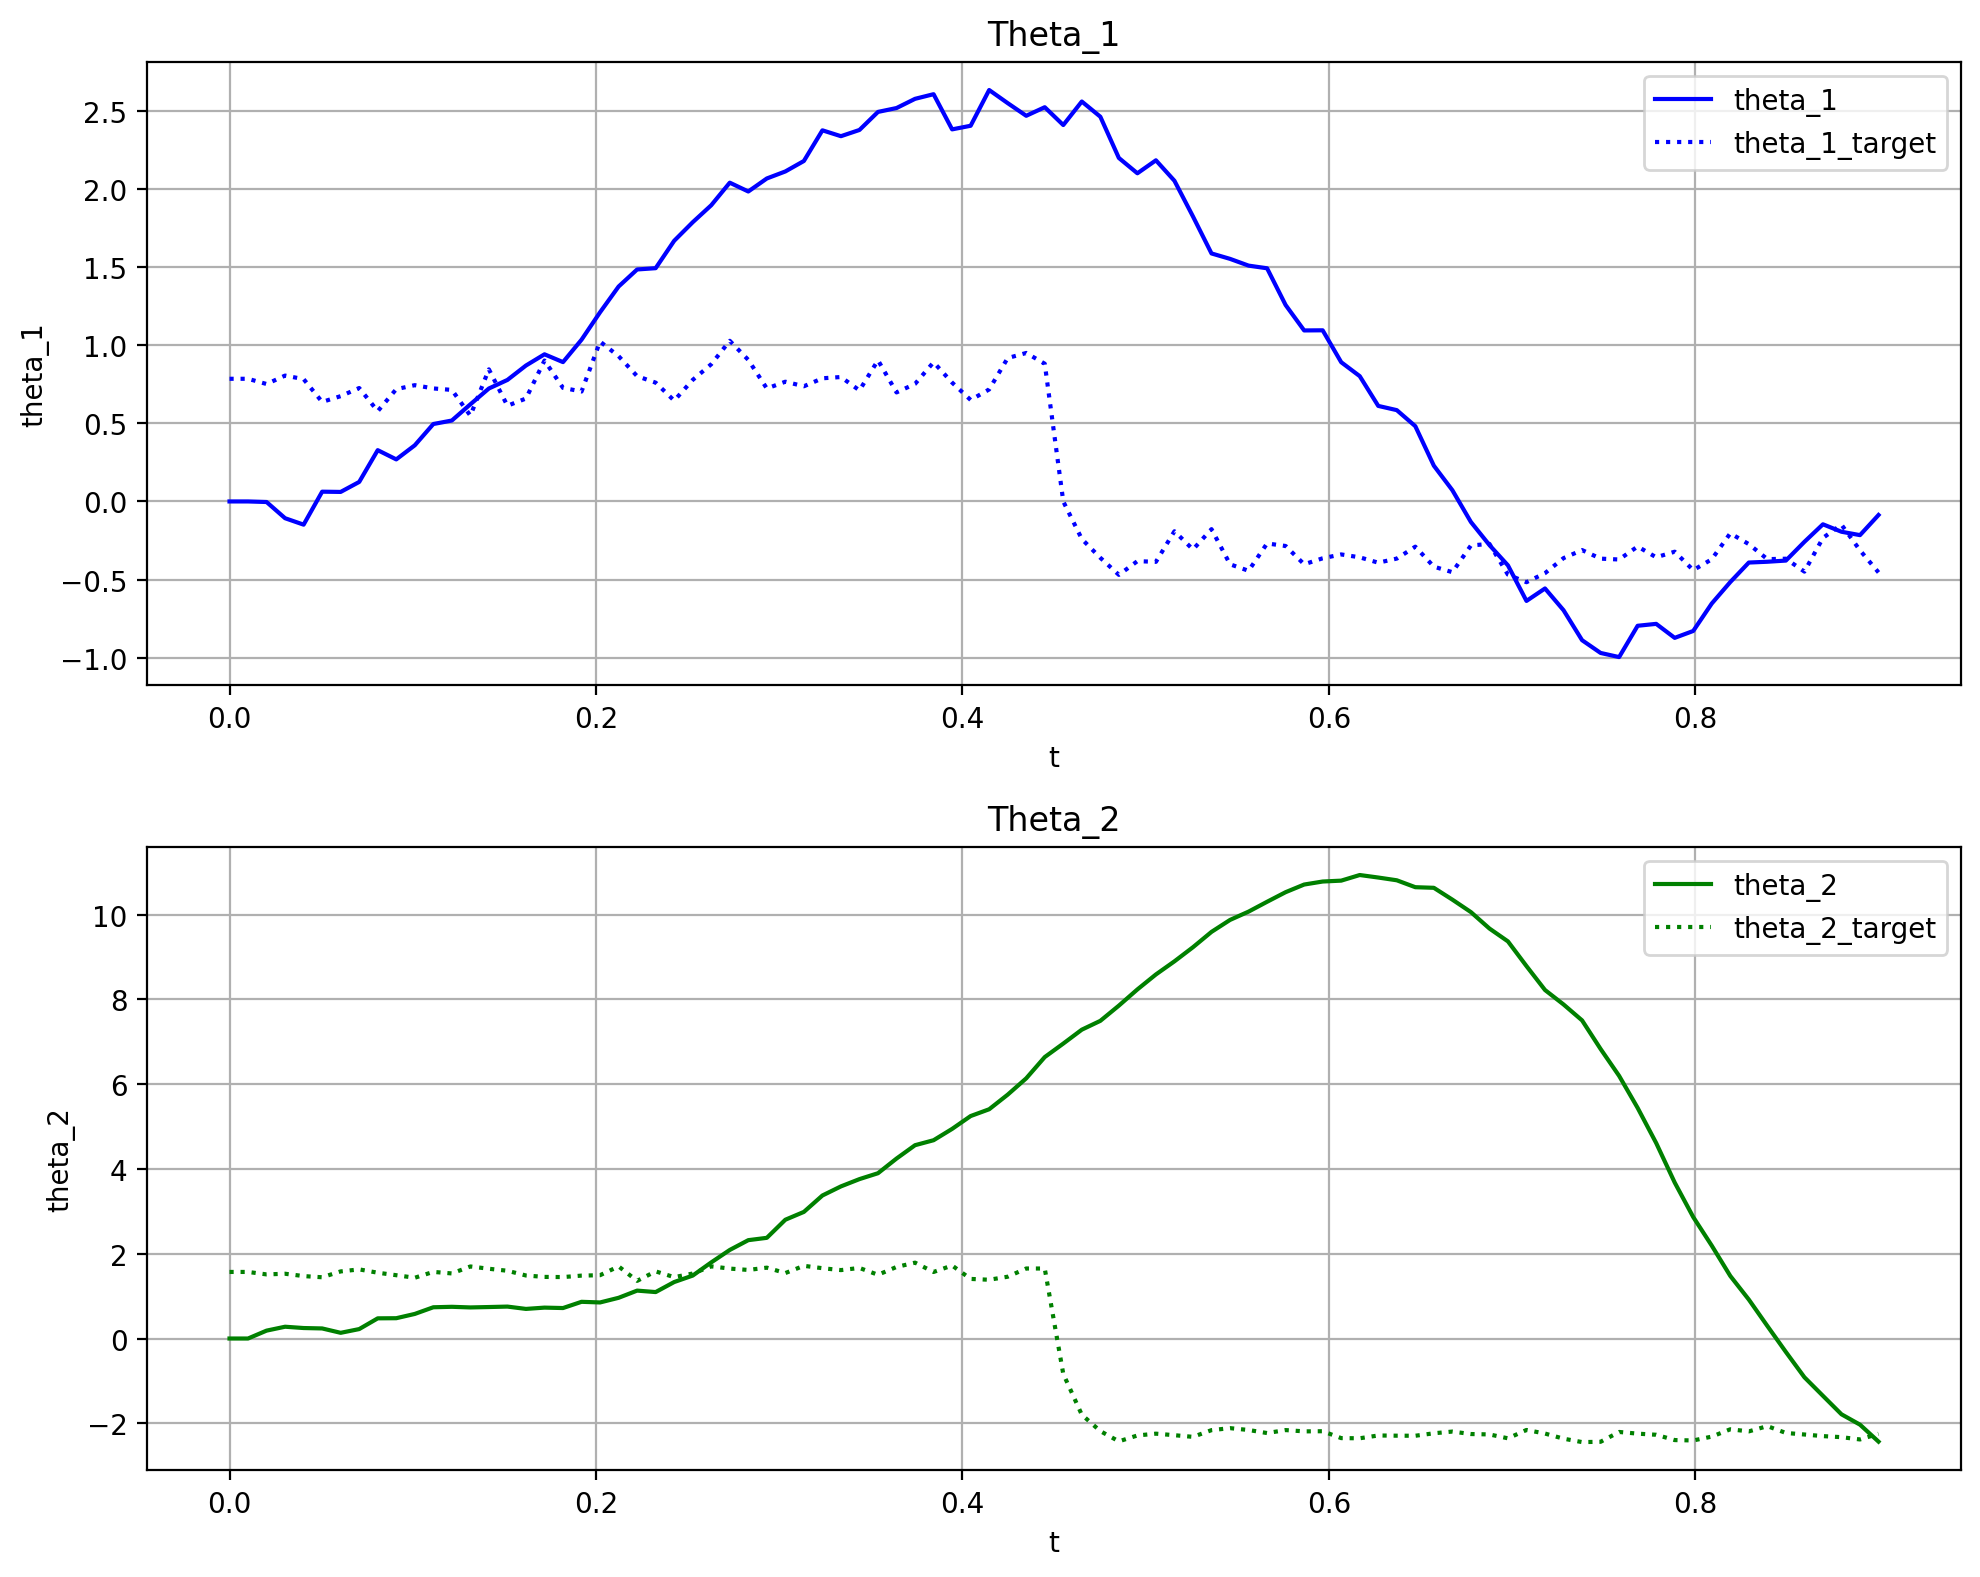

In [16]:
## Visualize target change simulation
nStep = int(np.round(motion_time/timestep))
t = np.linspace(0, motion_time, nStep)
theta_1_traj = []
theta_2_traj = []

theta_1_targ = []
theta_2_targ = []

for x_ in simulated_with_torque:
  theta_1_traj.append(x_[0])
  theta_2_traj.append(x_[1])
  theta_1_targ.append(x_[6])
  theta_2_targ.append(x_[7])
  

fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # 2 rows, 1 column

axs[0].plot(t, theta_1_traj, label="theta_1", color="blue")
axs[0].plot(t, theta_1_targ, label="theta_1_target", color="blue", linestyle="dotted")
axs[0].set_title("Theta_1")
axs[0].set_xlabel("t")
axs[0].set_ylabel("theta_1")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(t, theta_2_traj, label="theta_2", color="green")
axs[1].plot(t, theta_2_targ, label="theta_2_target", color="green", linestyle="dotted")
axs[1].set_title("Theta_2")
axs[1].set_xlabel("t")
axs[1].set_ylabel("theta_2")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [17]:
### Visualize arm from above, inspired by TP2
import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
my_layout = widgets.Layout()

@widgets.interact(
    timestamp=widgets.FloatSlider(0, min=0, max=len(simulated_with_torque)-1, step=1, layout=my_layout)

)

def visualize_arm(timestamp):
        
    l1 = 0.3
    l2 = 0.33

    # Extract the angles for the arm and the target
    theta_1, theta_2, _, _, _, _, theta_1_target, theta_2_target, _, _, _, _ = simulated_with_torque[int(timestamp)]

    # Function to compute the (x, y) coordinates of the joints and end effector
    def compute_positions(theta_1, theta_2, l1, l2):
        # Joint positions
        x1 = l1 * np.cos(theta_1)
        y1 = l1 * np.sin(theta_1)

        x2 = x1 + l2 * np.cos(theta_1 + theta_2)
        y2 = y1 + l2 * np.sin(theta_1 + theta_2)

        return (0, 0), (x1, y1), (x2, y2)

    # Compute positions for the current state
    base, joint, end_effector = compute_positions(theta_1, theta_2, l1, l2)

    # Compute positions for the target state
    _, target_joint, target_end_effector = compute_positions(theta_1_target, theta_2_target, l1, l2)

    # Visualization
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    ax.set_xlim(-0.8,0.8)
    ax.set_ylim(-0.6,0.8)

    # Plot the arm's current state
    ax.plot([base[0], joint[0], end_effector[0]], [base[1], joint[1], end_effector[1]], 
            marker='o', label='Current Arm State', color='blue')

    # Plot the target
    ax.scatter(target_end_effector[0], target_end_effector[1], 
            color='red', label='Target', s=100, zorder=5)

    # Add legend
    ax.legend()

    plt.show()


interactive(children=(FloatSlider(value=0.0, description='timestamp', max=89.0, step=1.0), Output()), _dom_cla…

## Question 5
Model with added delay, to do this we expand the state vector

In [36]:
def simulate_with_delay(move_from, move_to_initial, move_to_final, target_disturbance_time, motion_time, dt, external_torque, noise = 0.00025, time_delay = 0): 

    # Parameters ------------------------------------------------------------------------
    l1 = 0.3
    l2 = 0.33
    m1 = 1.4
    m2 = 1
    I1 = 0.025
    I2 = 0.045
    s1 = 0.11
    s2 = 0.16
    tau = 0.060 # Muscle activation time constant Source : (Li, 2007) -> voir énoncé
    # But the paper says 0.066 /!\

    x = np.concatenate((move_from, move_to_initial)) #the state vector contains the state and the target


    a1 = I1 + I2 + m2*(l2**2)
    a2 = m2*l1*s2
    a3 = I2

    B_param = np.array([[0.5, 0.025], # Used to be 0.05, 0.025
                        [0.025, 0.5]])
    M = np.array([[a1, a3],
                [a3, a3]])
    M_inv = np.linalg.inv(M)
    P = np.dot(M_inv, B_param) #intermediate matrix used to simplify the notations

    #State system, Eq 6-7
    A_c = np.array([[0, 0, 1,       0,      0,              0],
                    [0, 0, 0,       1,      0,              0,],
                    [0, 0, -P[0,0], -P[0,1], M_inv[0,0], M_inv[0,1]],
                    [0, 0, -P[1,0], -P[1,1], M_inv[1,0], M_inv[1,1]],
                    [0, 0, 0,       0,      -1/tau,         -1/tau],
                    [0, 0, 0,       0,      -1/tau,         -1/tau]])

    B_c = np.array([[0, 0, 0, 0, 1/tau, 0],
                    [0, 0, 0, 0, 0, 1/tau]]).T # Transpose because B_c needs nxm

    u_dim = 2 #control input of shape (2,1)
    n_dim = A_c.shape[0] #dim of the state vector
    A = np.eye(n_dim) + dt*A_c
    B = dt*B_c

    # Augmentation of the system matrices to include the target
    n_dim_augment = 2*n_dim
    A_temp = A
    A = np.zeros(shape=(n_dim_augment,n_dim_augment))
    A[0:n_dim,0:n_dim] = A_temp
    A[n_dim:n_dim_augment,n_dim:n_dim_augment] = np.identity(n_dim)

    B_temp = B
    B = np.zeros(shape=(n_dim_augment, u_dim))
    B[0:n_dim] = B_temp


    # Definition of the cost-function and time -------------------------------------
    simulation_time = motion_time
    nStep = int(np.round(simulation_time/dt))
    N = nStep - 1
    Q = np.zeros(shape=(nStep, n_dim_augment, n_dim_augment))
    R = np.zeros(shape=(u_dim, u_dim))

                # W1      W2    W3
    w = np.array([1.5,1.5, 1,1, 0.1,0.1]) # weights assigned to each term of the cost function

    for i in range(n_dim):
        ei = 0*np.ndarray(shape=(2*n_dim))
        ei[i] = 1
        ei[i+n_dim] = -1
        Q[N,:,:] = Q[N,:,:] + w[i]*np.outer(ei,ei)
    

    # Perform backward recurrence --------------------------------------------------
    S_list = [None] * (N + 1) #
    L_list = [None] * (N + 1)

    S_list[N] = Q[N]

    for k in range(N - 1, -1, -1):
        Sk_plus_1 = S_list[k + 1]
        temp = np.linalg.inv(R + B.T @ Sk_plus_1 @ B)
        temp = np.linalg.inv(R + B.T @ Sk_plus_1 @ B + np.eye(u_dim) * 1e-10)  # Regularization

        Lk = temp @ B.T @ Sk_plus_1 @ A

        S_list[k] = Q[k] + A.T @ Sk_plus_1 @ (A - B @ Lk)
        L_list[k] = Lk

    # Perform forward simulation ---------------------------------------------------
    H = np.eye(n_dim_augment) # Observation matrix

    noise_std = noise
    process_std = noise

    Omega_omega = np.eye(n_dim_augment)*noise_std # Measurement noise covariance
    Omega_xi = np.eye(n_dim_augment)*process_std # Process noise covariance

    # Storage for results
    y_list = [None] * N
    Sigma_list = [None] * (N + 1) # state covariance
    x_hat_list = [None] * (N + 1 + time_delay) # state estimate
    K_list = [None] * N # kalman gains
    u_list = [None] * N # input list

    # Set initial conditions
    Sigma_list[0] = np.zeros((n_dim_augment, n_dim_augment))
    x_hat_list[0] = x

    current_target = move_to_initial

    # Kalman filter iterations
    #### For initial target
    for k in range(N):
        Sigma_k = Sigma_list[k]
        x_hat_k = x_hat_list[k]

        if (k == int(np.floor(N * target_disturbance_time))):
            current_target = move_to_final

        L_k = L_list[k]

        # Generate noisy measurement
        omega_k = np.random.multivariate_normal(mean=np.zeros(n_dim_augment), cov=Omega_omega).reshape(-1, 1)[:,0]
        if k > time_delay:
            y_k = H @ np.concat((x_hat_list[k-time_delay][0:6], current_target)) + omega_k
        else:
            y_k = H @ np.concat((x_hat_list[0][0:6], current_target)) + omega_k
        y_list[k] = y_k

        # Compute control input
        u_k = -L_k @ x_hat_k

        # Compute Kalman gain
        temp = np.linalg.inv(H @ Sigma_k @ H.T + Omega_omega)
        K_k = A @ Sigma_k @ H.T @ temp

        # Update covariance matrix
        Sigma_list[k + 1] = Omega_xi + (A - K_k @ H) @ Sigma_k @ A.T

        # Update state estimate
        x_hat_list[k + 1] = A @ x_hat_k + B @ u_k + K_k @ (y_k - H @ x_hat_k) + external_torque

        # Store results
        K_list[k] = K_k
        u_list[k] = u_k
    

    return x_hat_list

In [39]:
timestep = 0.01
motion_time = 0.9
time_delay = 10

# indicates where in the simulation the target should be disturbed
target_disturbance_time = 0.5 ## This is a ratio between 0.0 and 1.0 of the above motion time

x0 = np.array([0, 0, 0, 0, 0, 0])
# xt_initial = np.array([theta_1_target, theta_2_target, theta_1_target/motion_time, theta_2_target/motion_time, 0, 0])
xt_initial = np.array([theta_1_target, theta_2_target, 0, 0, 0, 0])
# xt_final = xt_initial
xt_final = np.array([-target[0], -target[1], 0, 0, 0, 0]) 

torque_disturbance = [0,0,0,0,0,0,0,0,0,0,0,0]

simulated_with_delay = simulate_with_delay(x0, xt_initial, xt_final, target_disturbance_time, motion_time, timestep, torque_disturbance, time_delay)

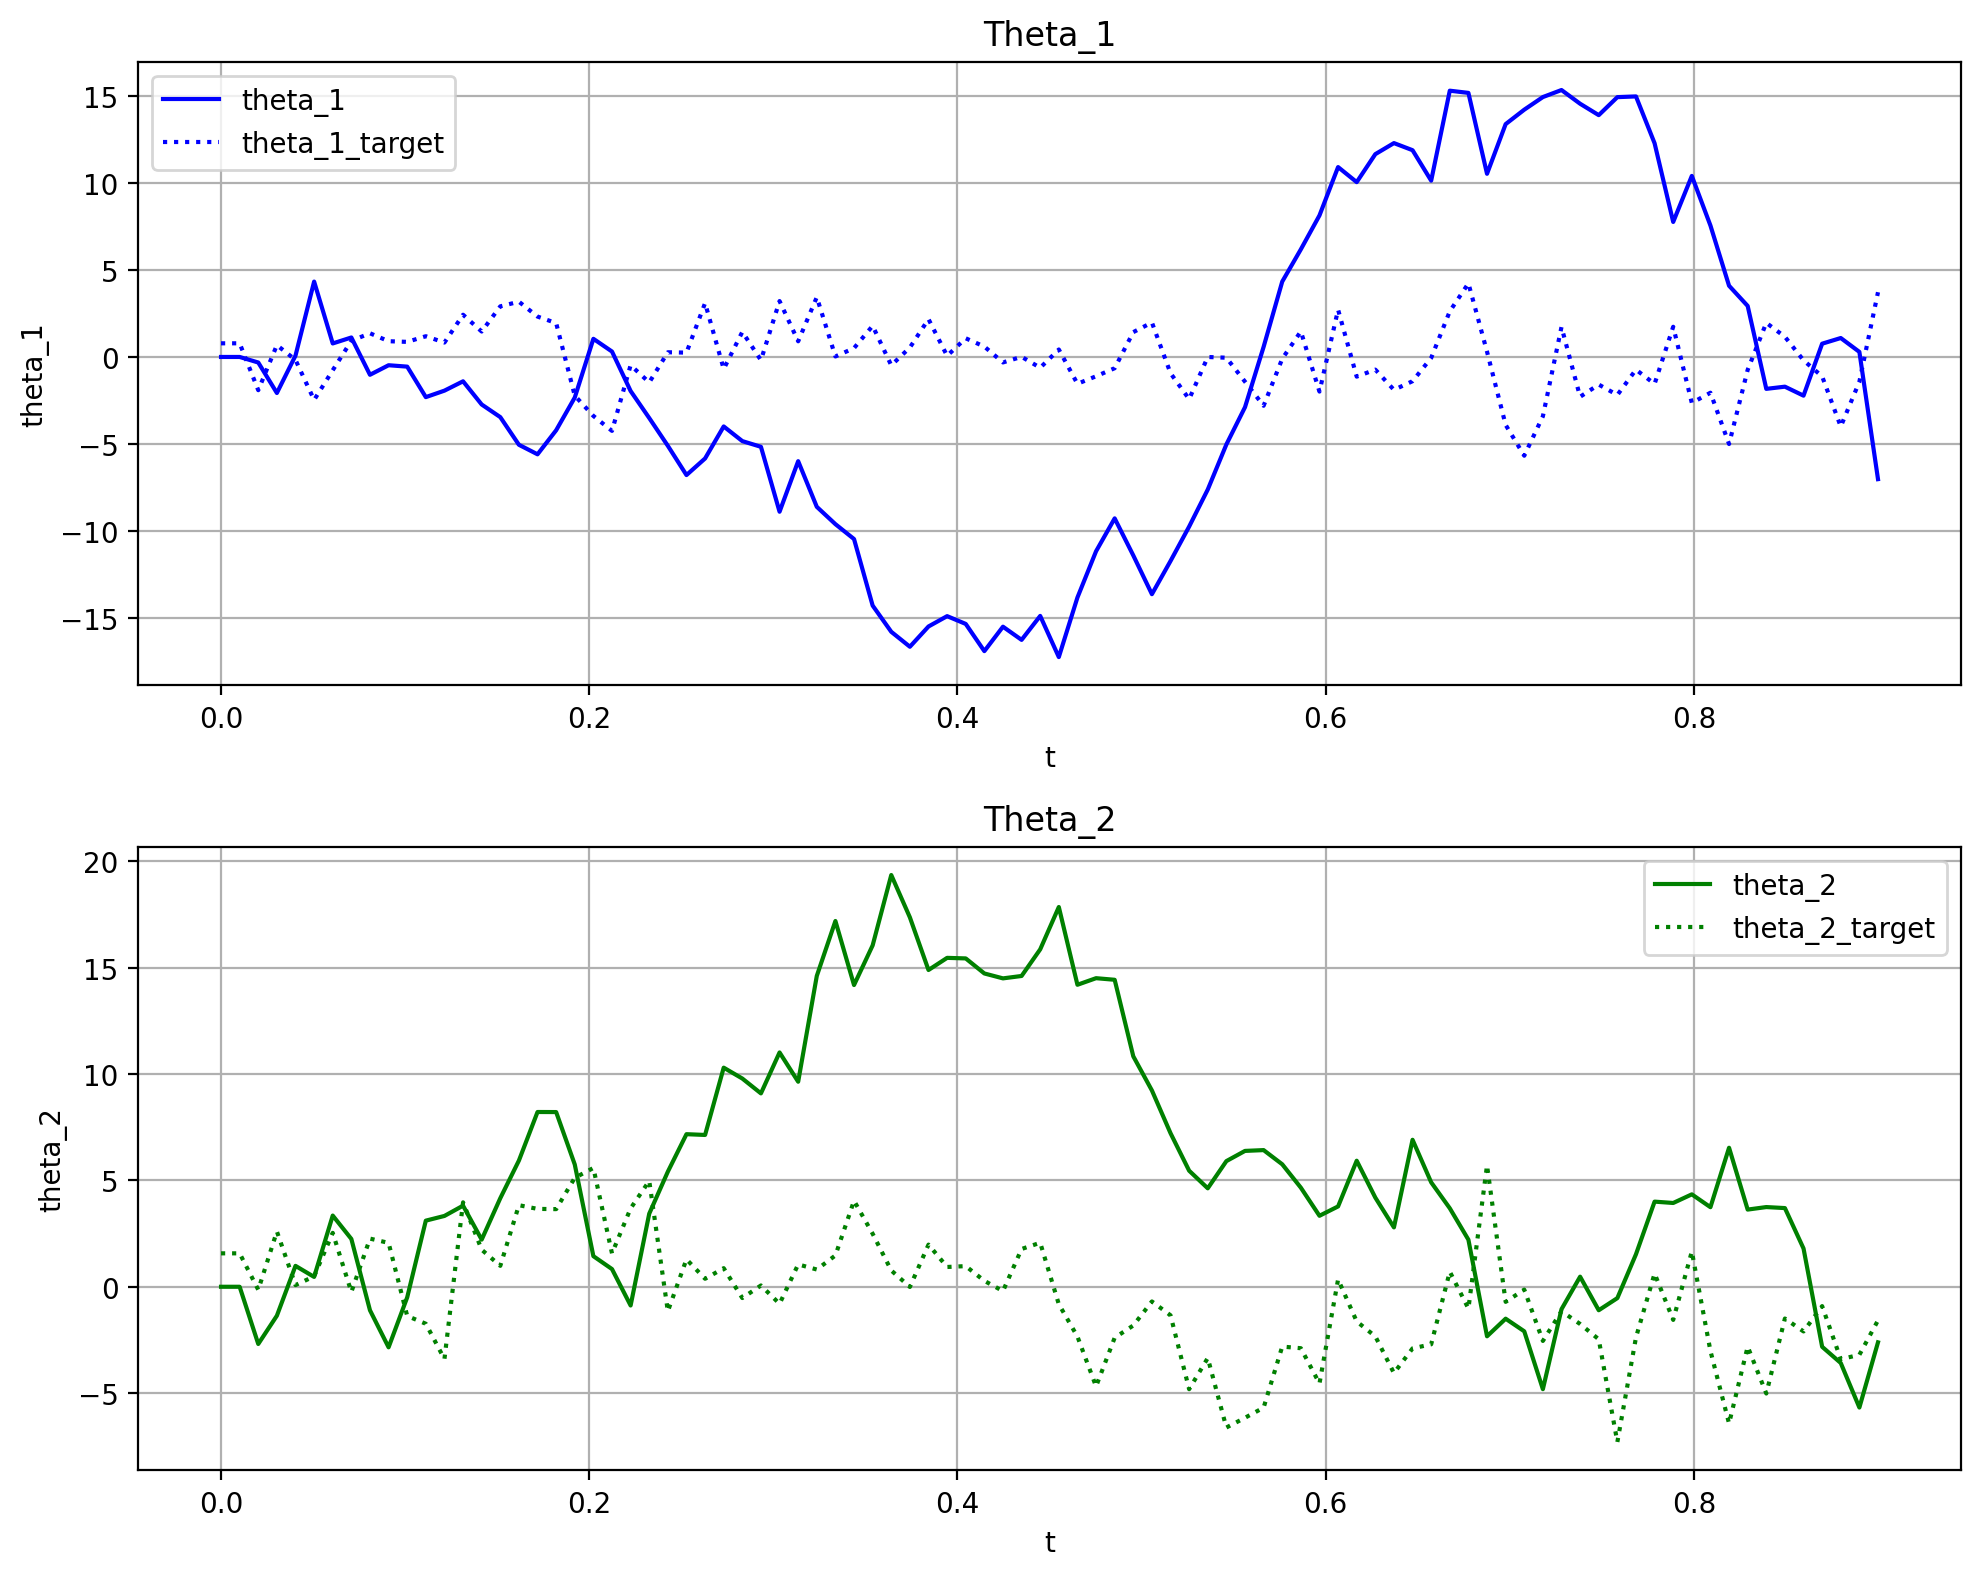

In [40]:
## Visualize target change simulation
nStep = int(np.round(motion_time/timestep))
t = np.linspace(0, motion_time, nStep)
theta_1_traj = []
theta_2_traj = []

theta_1_targ = []
theta_2_targ = []

for x_ in simulated_with_delay:
  theta_1_traj.append(x_[0])
  theta_2_traj.append(x_[1])
  theta_1_targ.append(x_[6])
  theta_2_targ.append(x_[7])
  

fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # 2 rows, 1 column

axs[0].plot(t, theta_1_traj, label="theta_1", color="blue")
axs[0].plot(t, theta_1_targ, label="theta_1_target", color="blue", linestyle="dotted")
axs[0].set_title("Theta_1")
axs[0].set_xlabel("t")
axs[0].set_ylabel("theta_1")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(t, theta_2_traj, label="theta_2", color="green")
axs[1].plot(t, theta_2_targ, label="theta_2_target", color="green", linestyle="dotted")
axs[1].set_title("Theta_2")
axs[1].set_xlabel("t")
axs[1].set_ylabel("theta_2")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
### Visualize arm from above, inspired by TP2
import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
my_layout = widgets.Layout()

@widgets.interact(
    timestamp=widgets.FloatSlider(0, min=0, max=len(simulated_with_delay)-1, step=1, layout=my_layout)

)

def visualize_arm(timestamp):
        
    l1 = 0.3
    l2 = 0.33

    # Extract the angles for the arm and the target
    theta_1, theta_2, _, _, _, _, theta_1_target, theta_2_target, _, _, _, _ = simulated_with_delay[int(timestamp)]

    # Function to compute the (x, y) coordinates of the joints and end effector
    def compute_positions(theta_1, theta_2, l1, l2):
        # Joint positions
        x1 = l1 * np.cos(theta_1)
        y1 = l1 * np.sin(theta_1)

        x2 = x1 + l2 * np.cos(theta_1 + theta_2)
        y2 = y1 + l2 * np.sin(theta_1 + theta_2)

        return (0, 0), (x1, y1), (x2, y2)

    # Compute positions for the current state
    base, joint, end_effector = compute_positions(theta_1, theta_2, l1, l2)

    # Compute positions for the target state
    _, target_joint, target_end_effector = compute_positions(theta_1_target, theta_2_target, l1, l2)

    # Visualization
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    ax.set_xlim(-0.8,0.8)
    ax.set_ylim(-0.6,0.8)

    # Plot the arm's current state
    ax.plot([base[0], joint[0], end_effector[0]], [base[1], joint[1], end_effector[1]], 
            marker='o', label='Current Arm State', color='blue')

    # Plot the target
    ax.scatter(target_end_effector[0], target_end_effector[1], 
            color='red', label='Target', s=100, zorder=5)

    # Add legend
    ax.legend()

    plt.show()


interactive(children=(FloatSlider(value=0.0, description='timestamp', max=89.0, step=1.0), Output()), _dom_cla…